In [1]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import timm
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from vncorenlp import VnCoreNLP
from tqdm import tqdm

/home/phongdtd/minhhnh/image_search/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CFG:
    debug = False
    image_path = "input/flickr-image-dataset/flickr30k_images/flickr30k_images"
    captions_path = "input"
    batch_size = 16
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 3e-4
    text_encoder_lr = 3e-5
    weight_decay = 1e-3
    factor = 0.8
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model_vn = "vinai/phobert-base"
    text_embedding = 768
    text_tokenizer_vn = "vinai/phobert-base"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 336

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 512 
    dropout = 0.1
    
    # for early stopping
    the_last_loss = 100
    patience = 3
    trigger_times = 0
    isStopped = False
    
    # for plotting
    train_loss_history = []
    val_loss_history = []

In [3]:
annotator = VnCoreNLP(
    "input/vncorenlp/VnCoreNLP-master/VnCoreNLP-1.1.1.jar",
    annotators="wseg",
    max_heap_size="-Xmx500m",
)
tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer_vn, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
specialchars = [
    "~",
    ":",
    "'",
    "+",
    "[",
    "\\",
    "@",
    "^",
    "{",
    "%",
    "(",
    "-",
    '"',
    "*",
    "|",
    ",",
    "&",
    "<",
    "`",
    "}",
    ".",
    "_",
    "=",
    "]",
    "!",
    ">",
    ";",
    "?",
    "#",
    "$",
    ")",
    "/",
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]


def word_segmentation_one(query):
    for c in specialchars:
        if c in query:
            query = query.replace(c, "")
    word_segmented_text = np.squeeze(annotator.tokenize(query))
    try:
        query = " ".join(map(str, word_segmented_text))
    except:
        print("one word: ", word_segmented_text)
        return True, word_segmented_text
    return False, query

In [5]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [6]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        self.image_filenames = image_filenames
        self.captions = captions
        self.encoded_captions = tokenizer(
            list(self.captions),
            padding=True,
            truncation=True,
            max_length=CFG.max_length,
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)["image"]
        item["image"] = torch.tensor(image).permute(2, 0, 1).float()
        item["caption"] = self.captions[idx]
        return item

    def __len__(self):
        return len(self.captions)


def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.RandomRotate90(),
                A.Flip(),
                A.Transpose(),
                A.OneOf(
                    [
                        A.GaussNoise(),
                    ],
                    p=0.2,
                ),
                A.OneOf(
                    [
                        A.MotionBlur(p=0.2),
                        A.MedianBlur(blur_limit=3, p=0.1),
                        A.Blur(blur_limit=3, p=0.1),
                    ],
                    p=0.2,
                ),
                A.ShiftScaleRotate(
                    shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2
                ),
                A.OneOf(
                    [
                        A.OpticalDistortion(p=0.3),
                        A.GridDistortion(p=0.1),
                        A.PiecewiseAffine(p=0.3),
                    ],
                    p=0.2,
                ),
                A.OneOf(
                    [
                        A.CLAHE(clip_limit=2),
                        A.Sharpen(),
                        A.Emboss(),
                        A.RandomBrightnessContrast(),
                    ],
                    p=0.3,
                ),
                A.HueSaturationValue(p=0.3),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [7]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self,
        model_name=CFG.model_name,
        pretrained=CFG.pretrained,
        trainable=CFG.trainable,
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [8]:
class TextEncoder(nn.Module):
    def __init__(
        self,
        model_name=CFG.text_encoder_model_vn,
        pretrained=CFG.pretrained,
        trainable=CFG.trainable,
    ):
        super().__init__()
        self.model = AutoModel.from_pretrained(CFG.text_encoder_model_vn)

        for p in self.model.parameters():
            p.requires_grad = trainable

        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [9]:
class ProjectionHead(nn.Module):
    def __init__(
        self, embedding_dim, projection_dim=CFG.projection_dim, dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [10]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction="none")
        images_loss = cross_entropy(logits.T, targets.T, reduction="none")
        loss = (images_loss + texts_loss) / 2.0  # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction="none"):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [11]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/word_segmented.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.1 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [12]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [13]:
train_df, valid_df = make_train_valid_dfs()

In [14]:
def main():
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {
            "params": itertools.chain(
                model.image_projection.parameters(), model.text_projection.parameters()
            ),
            "lr": CFG.head_lr,
            "weight_decay": CFG.weight_decay,
        },
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.0)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float("inf")
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        CFG.train_loss_history.append(train_loss.avg)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        CFG.val_loss_history.append(valid_loss.avg)

        #         if valid_loss.avg < best_loss:
        #             best_loss = valid_loss.avg
        #             torch.save(model.state_dict(), "best_resnet50.pt")
        #             print("Saved Best Model!")
        if valid_loss.avg > CFG.the_last_loss:
            CFG.trigger_times += 1
            print("Trigger times: ", CFG.trigger_times)
            if CFG.trigger_times >= CFG.patience:
                print("Early stopping! at epoch {0}".format(epoch + 1))
                CFG.isStopped = True
                break
        else:
            print("trigger times: 0")
            CFG.trigger_times = 0
            CFG.the_last_loss = valid_loss.avg
            if not CFG.isStopped:
                torch.save(model.state_dict(), CFG.model_name + ".pt")
                print(
                    "Validation loss {:.6f}.  Saving model ...".format(valid_loss.avg)
                )

        lr_scheduler.step(valid_loss.avg)

In [15]:
main()

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1


100%|██████████| 994/994 [02:25<00:00,  6.85it/s, valid_loss=2.07]


trigger times: 0
Validation loss 2.072027.  Saving model ...
Epoch: 2


100%|██████████| 994/994 [02:27<00:00,  6.72it/s, valid_loss=1.95]


trigger times: 0
Validation loss 1.950938.  Saving model ...
Epoch: 3


100%|██████████| 994/994 [02:25<00:00,  6.85it/s, valid_loss=2.08]


Trigger times:  1
Epoch: 4


100%|██████████| 994/994 [02:27<00:00,  6.73it/s, valid_loss=2.04]


Trigger times:  2
Epoch: 5


100%|██████████| 994/994 [02:24<00:00,  6.86it/s, valid_loss=2.1] 


Trigger times:  3
Early stopping! at epoch 5


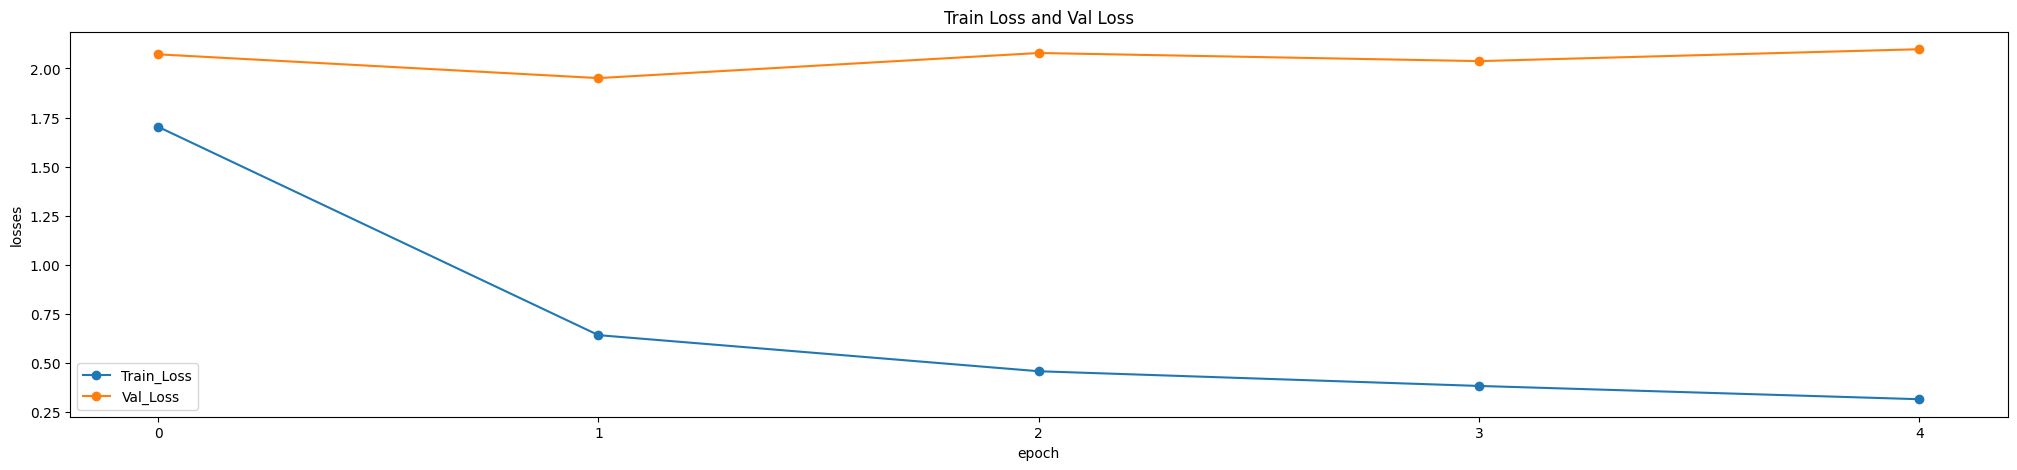

In [16]:
import matplotlib.ticker as mticker

plt.figure(figsize=(25, 5))
plt.plot(CFG.train_loss_history, "-o")
plt.plot(CFG.val_loss_history, "-o")
plt.xlabel("epoch")
plt.ylabel("losses")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(["Train_Loss", "Val_Loss"])
plt.title("Train Loss and Val Loss")
plt.show()

In [17]:
def get_image_embeddings(valid_df, model_path):
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [18]:
def find_matches(model, image_embeddings, query, image_filenames, n=9, plot=True):
    only_one_word, query = word_segmentation_one(query)
    #     print(query)
    if only_one_word:
        encoded_query = tokenizer([str(query)])
    else:
        encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    if plot:
        _, axes = plt.subplots(3, 3, figsize=(10, 10))
        for match, ax in zip(matches, axes.flatten()):
            image = cv2.imread(f"{CFG.image_path}/{match}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image)
            ax.axis("off")

        plt.show()
    return matches

In [19]:
model, image_embeddings = get_image_embeddings(valid_df, CFG.model_name + ".pt")

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 994/994 [01:42<00:00,  9.72it/s]


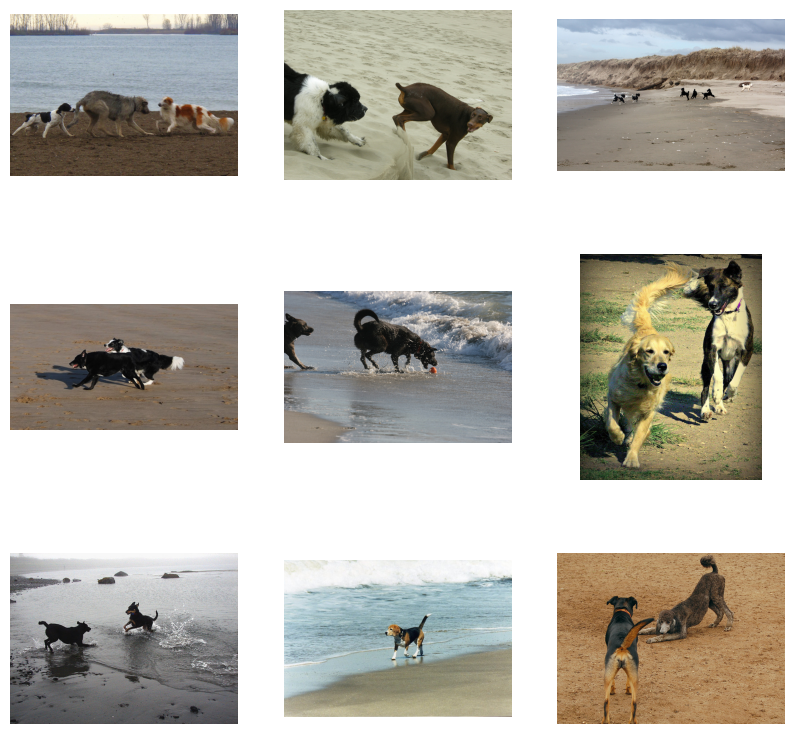

['3492383096.jpg',
 '1067790824.jpg',
 '3324056835.jpg',
 '2913818905.jpg',
 '350529848.jpg',
 '1095590286.jpg',
 '1425013325.jpg',
 '953941506.jpg',
 '2464259416.jpg']

In [20]:
find_matches(
    model,
    image_embeddings,
    query="hai con chó trên bờ biển",
    image_filenames=valid_df["image"].values,
    n=9,
)

In [21]:
def compute_top_k_accuracy(image_paths, caption_paths, k):
    hits = 0
    num_batches = int(np.ceil(len(image_paths) / CFG.batch_size))
    for idx in tqdm(range(num_batches)):
        start_idx = idx * CFG.batch_size
        end_idx = start_idx + CFG.batch_size
        current_image_paths = image_paths[start_idx:end_idx]
        #         print(current_image_paths,len(current_image_paths))
        queries = caption_paths[start_idx * 5 : end_idx * 5 : 5]
        for query in queries:
            query = query.replace("_", " ")
        #             print(query)
        #         print(queries,len(queries))
        for image_path, query in zip(current_image_paths, queries):
            matches = find_matches(
                model,
                image_embeddings,
                query,
                valid_df["image"].values,
                n=k,
                plot=False,
            )
            #             print(len(matches))
            if image_path in matches:
                hits += 1
    #         print('hits',hits)
    #         break
    return hits / len(image_paths)

In [23]:
image_paths = valid_df["image"].values[::5]
caption_paths = valid_df["caption"].values
acc = compute_top_k_accuracy(image_paths, caption_paths, k=100)
print(f"Eval accuracy: {round(acc * 100, 3)}%")

100%|██████████| 199/199 [00:27<00:00,  7.32it/s]

Eval accuracy: 75.582%
